### Load the data from customers, orders, order_reviews and order_pymnts useful table (other tables are not used in this notebook)

In [508]:
import pandas as pd
import sqlite3
import os

# Relative path to the database
db_path = os.path.join('..', 'data', 'olist.db')
conn = sqlite3.connect(db_path)

# Load the tables into DataFrames
customers = pd.read_sql_query("SELECT * FROM customers", conn)
orders = pd.read_sql_query("SELECT * FROM orders", conn)
order_reviews = pd.read_sql_query("SELECT * FROM order_reviews", conn)
order_pymts = pd.read_sql_query("SELECT * FROM order_pymts", conn)
order_items = pd.read_sql_query("SELECT * FROM order_items", conn)
products = pd.read_sql_query("SELECT * FROM products", conn)


conn.close()

print("Data loaded successfully.")


Data loaded successfully.


### Merge the data from the useful different tables

In [509]:
import pandas as pd
import sqlite3
import os

# Relative path to the database
db_path = os.path.join('..', 'data', 'olist.db')
conn = sqlite3.connect(db_path)

# Load the tables into DataFrames
customers = pd.read_sql_query("SELECT * FROM customers", conn)
orders = pd.read_sql_query("SELECT * FROM orders", conn)
order_reviews = pd.read_sql_query("SELECT * FROM order_reviews", conn)
order_pymts = pd.read_sql_query("SELECT * FROM order_pymts", conn)
order_items = pd.read_sql_query("SELECT * FROM order_items", conn)
products = pd.read_sql_query("SELECT * FROM products", conn)

conn.close()

print("Data loaded successfully.")

# Merge the orders and customers tables
orders_customers = pd.merge(orders, customers, on='customer_id', how='inner', suffixes=('_order', '_customer'))

# Aggregate reviews by order_id
order_reviews_agg = order_reviews.groupby('order_id').agg({
    'review_score': 'mean',
    'review_id': 'count'
}).rename(columns={'review_score': 'avg_review_score', 'review_id': 'review_count'}).reset_index()

# Aggregate payments by order_id
order_pymts_agg = order_pymts.groupby('order_id').agg({
    'payment_value': 'sum',
    'payment_sequential': 'count',
    'payment_type': lambda x: ', '.join(x.unique())
}).rename(columns={'payment_value': 'total_payment_value', 'payment_sequential': 'payment_count', 'payment_type': 'payment_types'}).reset_index()

# Merge order items with products
order_items_products = pd.merge(order_items, products, on='product_id', how='left')

# Aggregate order items with products by order_id
order_items_agg = order_items_products.groupby('order_id').agg({
    'price': 'sum',
    'order_item_id': 'count',
    'product_category_name': lambda x: ', '.join(x.fillna('').unique()),
    'product_weight_g': 'mean',
    'product_length_cm': 'mean',
    'product_height_cm': 'mean',
    'product_width_cm': 'mean'
}).rename(columns={
    'price': 'total_price', 
    'order_item_id': 'item_count',
    'product_category_name': 'product_categories',
    'product_weight_g': 'avg_product_weight_g',
    'product_length_cm': 'avg_product_length_cm',
    'product_height_cm': 'avg_product_height_cm',
    'product_width_cm': 'avg_product_width_cm'
}).reset_index()

# Merge the aggregated reviews with orders_customers
orders_customers_reviews = pd.merge(orders_customers, order_reviews_agg, on='order_id', how='left')

# Merge the aggregated payments with orders_customers_reviews
orders_customers_reviews_payments = pd.merge(orders_customers_reviews, order_pymts_agg, on='order_id', how='left')

# Merge the aggregated order items with orders_customers_reviews_payments
df_final = pd.merge(orders_customers_reviews_payments, order_items_agg, on='order_id', how='left')

# Perform a control on the number of rows before and after merge
initial_row_count = len(orders)
final_row_count = len(df_final)
print(f"Initial row count in orders table: {initial_row_count}")
print(f"Final row count in df_final: {final_row_count}")

# Drop the customer_id column to avoid confusion
df_final.drop(columns=['customer_id'], inplace=True)

# Use only 'customer_unique_id' to identify each customer
df_final = df_final[['customer_unique_id'] + [col for col in df_final.columns if col != 'customer_unique_id']]

print("Tables merged successfully, data aggregated, and 'customer_id' column removed.")
df_final.head()


Data loaded successfully.
Initial row count in orders table: 99441
Final row count in df_final: 99441
Tables merged successfully, data aggregated, and 'customer_id' column removed.


,customer_unique_id,index_order,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_customer,...,total_payment_value,payment_count,payment_types,total_price,item_count,product_categories,avg_product_weight_g,avg_product_length_cm,avg_product_height_cm,avg_product_width_cm
0,7c396fd4830fd04220f754e42b4e5bff,0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,70296,...,38.71,3.0,"credit_card, voucher",29.99,1.0,utilidades_domesticas,500.0,19.0,8.0,13.0
1,af07308b275d755c9edb36a90c618231,1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,77027,...,141.46,1.0,boleto,118.70,1.0,perfumaria,400.0,19.0,13.0,19.0
2,3a653a41f6f9fc3d2a113cf8398680e8,2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,554,...,179.12,1.0,credit_card,159.90,1.0,automotivo,420.0,24.0,19.0,21.0
3,7c142cf63193a1473d2e66489a9ae977,3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,61081,...,72.20,1.0,credit_card,45.00,1.0,pet_shop,450.0,30.0,10.0,20.0
4,72632f0f9dd73dfee390c9b22eb56dd6,4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,67263,...,28.62,1.0,credit_card,19.90,1.0,papelaria,250.0,51.0,15.0,15.0


In [510]:
df_final.shape

(99441, 25)

In [511]:
df_final.tail(5)

,customer_unique_id,index_order,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_customer,...,total_payment_value,payment_count,payment_types,total_price,item_count,product_categories,avg_product_weight_g,avg_product_length_cm,avg_product_height_cm,avg_product_width_cm
99436,6359f309b166b0196dbf7ad2ac62bb5a,99436,9c5dedf39a927c1b2549525ed64a053c,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,60577,...,85.08,1.0,credit_card,72.00,1.0,beleza_saude,1175.0,22.0,13.0,18.0
99437,da62f9e57a76d978d02ab5362c509660,99437,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,78424,...,195.00,1.0,credit_card,174.90,1.0,bebes,4950.0,40.0,10.0,40.0
99438,737520a9aad80b3fbbdad19b66b37b30,99438,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,19901,...,271.01,1.0,credit_card,205.99,1.0,eletrodomesticos_2,13300.0,32.0,90.0,22.0
99439,5097a5312c8b157bb7be58ae360ef43c,99439,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,16923,...,441.16,1.0,credit_card,359.98,2.0,informatica_acessorios,6550.0,20.0,20.0,20.0
99440,60350aa974b26ff12caad89e55993bd6,99440,66dea50a8b16d9b4dee7af250b4be1a5,delivered,2018-03-08 20:57:30,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03 00:00:00,38125,...,86.86,1.0,debit_card,68.50,1.0,beleza_saude,150.0,16.0,7.0,15.0


In [512]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_unique_id             99441 non-null  object 
 1   index_order                    99441 non-null  int64  
 2   order_id                       99441 non-null  object 
 3   order_status                   99441 non-null  object 
 4   order_purchase_timestamp       99441 non-null  object 
 5   order_approved_at              99281 non-null  object 
 6   order_delivered_carrier_date   97658 non-null  object 
 7   order_delivered_customer_date  96476 non-null  object 
 8   order_estimated_delivery_date  99441 non-null  object 
 9   index_customer                 99441 non-null  int64  
 10  customer_zip_code_prefix       99441 non-null  int64  
 11  customer_city                  99441 non-null  object 
 12  customer_state                 99441 non-null 

In [513]:
import pandas as pd

# Identify categorical variables
categorical_vars = df_final.select_dtypes(include=['object']).columns

print("Categorical variables identified in df_final:")
print(categorical_vars)



Categorical variables identified in df_final:
Index(['customer_unique_id', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_city', 'customer_state',
       'payment_types', 'product_categories'],
      dtype='object')


In [514]:
# Check for missing values
missing_values = df_final.isnull().sum()
missing_values

customer_unique_id                  0
index_order                         0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
index_customer                      0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
avg_review_score                  768
review_count                      768
total_payment_value                 1
payment_count                       1
payment_types                       1
total_price                       775
item_count                        775
product_categories                775
avg_product_weight_g              791
avg_product_length_cm             791
avg_product_height_cm             791
avg_product_width_cm              791
dtype: int64

### Missing Values:
### Summary for Replacing Missing Values in Date Columns

The strategy for replacing missing values in date columns aims to maintain temporal consistency in the data:

- **`order_approved_at`:** If missing, replace with `order_purchase_timestamp` as the order must have been approved at least by the purchase date.
- **`order_delivered_carrier_date`:** If missing, use `order_estimated_delivery_date` since the estimated delivery is often based on the expected shipping date.
- **`order_delivered_customer_date`:** If missing, substitute with `order_estimated_delivery_date` because it provides the best estimate of the actual delivery date.

This approach ensures logical and consistent temporal data for accurate analysis and modeling.

In [515]:
import pandas as pd
import numpy as np
import os


# Convert identified columns to datetime format
date_columns = [
    'order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date', 
    'order_estimated_delivery_date'
]

df_final[date_columns] = df_final[date_columns].apply(pd.to_datetime, errors='coerce')

# Replace missing values in date columns with other available dates or pd.NaT
df_final['order_approved_at'] = df_final['order_approved_at'].fillna(df_final['order_purchase_timestamp'])
df_final['order_delivered_carrier_date'] = df_final['order_delivered_carrier_date'].fillna(df_final['order_estimated_delivery_date'])
df_final['order_delivered_customer_date'] = df_final['order_delivered_customer_date'].fillna(df_final['order_estimated_delivery_date'])

# Convert dates to numerical format (e.g., number of days since order_purchase_timestamp)
df_final['days_to_approval'] = (df_final['order_approved_at'] - df_final['order_purchase_timestamp']).dt.days
df_final['days_in_transit'] = (df_final['order_delivered_carrier_date'] - df_final['order_approved_at']).dt.days
df_final['days_to_delivery'] = (df_final['order_delivered_customer_date'] - df_final['order_delivered_carrier_date']).dt.days
df_final['days_early_or_late'] = (df_final['order_delivered_customer_date'] - df_final['order_estimated_delivery_date']).dt.days

# Handle missing numerical values
numerical_columns = [
    'total_payment_value', 'payment_count', 'total_price', 'item_count', 
    'avg_review_score', 'review_count', 'avg_product_weight_g', 
    'avg_product_length_cm', 'avg_product_height_cm', 'avg_product_width_cm'
]
for col in numerical_columns:
    median_value = df_final[col].median()
    df_final[col].fillna(median_value, inplace=True)

# Handle missing categorical values
categorical_columns = ['payment_types', 'product_categories']
for col in categorical_columns:
    df_final[col].fillna('Unknown', inplace=True)

# Check for missing values after processing
missing_values_after = df_final.isnull().sum()
missing_values_after

customer_unique_id               0
index_order                      0
order_id                         0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
index_customer                   0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
avg_review_score                 0
review_count                     0
total_payment_value              0
payment_count                    0
payment_types                    0
total_price                      0
item_count                       0
product_categories               0
avg_product_weight_g             0
avg_product_length_cm            0
avg_product_height_cm            0
avg_product_width_cm             0
days_to_approval                 0
days_in_transit                  0
days_to_delivery                 0
days_early_or_late  

In [516]:
df_final.head(5)

,customer_unique_id,index_order,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_customer,...,item_count,product_categories,avg_product_weight_g,avg_product_length_cm,avg_product_height_cm,avg_product_width_cm,days_to_approval,days_in_transit,days_to_delivery,days_early_or_late
0,7c396fd4830fd04220f754e42b4e5bff,0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,70296,...,1.0,utilidades_domesticas,500.0,19.0,8.0,13.0,0,2,6,-8
1,af07308b275d755c9edb36a90c618231,1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,77027,...,1.0,perfumaria,400.0,19.0,13.0,19.0,1,0,12,-6
2,3a653a41f6f9fc3d2a113cf8398680e8,2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,554,...,1.0,automotivo,420.0,24.0,19.0,21.0,0,0,9,-18
3,7c142cf63193a1473d2e66489a9ae977,3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,61081,...,1.0,pet_shop,450.0,30.0,10.0,20.0,0,3,9,-13
4,72632f0f9dd73dfee390c9b22eb56dd6,4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,67263,...,1.0,papelaria,250.0,51.0,15.0,15.0,0,0,1,-10


In [517]:
# Check duplicates values
df_final.duplicated().sum()

0

In [518]:
# Summary statistics
df_final.describe()

,index_order,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_customer,customer_zip_code_prefix,avg_review_score,review_count,...,total_price,item_count,avg_product_weight_g,avg_product_length_cm,avg_product_height_cm,avg_product_width_cm,days_to_approval,days_in_transit,days_to_delivery,days_early_or_late
count,99441.000000,99441,99441,99441,99441,99441,99441.000000,99441.000000,99441.000000,99441.000000,...,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000
mean,49720.000000,2017-12-31 08:43:12.776581120,2017-12-31 19:07:21.164720896,2018-01-03 23:29:23.449764096,2018-01-13 06:50:40.982220800,2018-01-24 03:08:37.730111232,49720.000000,35137.474583,4.093846,1.005541,...,137.357742,1.140626,2092.014027,30.059371,16.457336,22.998700,0.269366,2.679589,8.863477,-11.522752
min,0.000000,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-09-30 00:00:00,2016-09-30 00:00:00,2016-09-30 00:00:00,0.000000,1003.000000,1.000000,1.000000,...,0.850000,1.000000,0.000000,7.000000,2.000000,6.000000,0.000000,-172.000000,-17.000000,-147.000000
25%,24860.000000,2017-09-12 14:46:19,2017-09-12 21:55:13,2017-09-14 23:13:41,2017-09-22 21:28:06,2017-10-03 00:00:00,24860.000000,11347.000000,4.000000,1.000000,...,45.990000,1.000000,300.000000,18.000000,8.000000,15.000000,0.000000,0.000000,4.000000,-17.000000
50%,49720.000000,2018-01-18 23:04:36,2018-01-19 11:54:30,2018-01-23 20:32:30,2018-02-01 19:34:49,2018-02-15 00:00:00,49720.000000,24416.000000,5.000000,1.000000,...,86.900000,1.000000,700.000000,25.000000,13.000000,20.000000,0.000000,1.000000,7.000000,-12.000000
75%,74580.000000,2018-05-04 15:42:16,2018-05-04 23:50:21,2018-05-08 11:19:00,2018-05-15 17:51:03,2018-05-25 00:00:00,74580.000000,58900.000000,5.000000,1.000000,...,149.900000,1.000000,1800.000000,37.000000,20.000000,30.000000,0.000000,3.000000,12.000000,-7.000000
max,99440.000000,2018-10-17 17:30:18,2018-10-17 17:30:18,2018-11-12 00:00:00,2018-11-12 00:00:00,2018-11-12 00:00:00,99440.000000,99990.000000,5.000000,3.000000,...,13440.000000,21.000000,40425.000000,105.000000,105.000000,118.000000,187.000000,144.000000,205.000000,188.000000
std,28706.288396,NaN,NaN,NaN,NaN,NaN,28706.288396,29797.938996,1.343446,0.074772,...,209.870343,0.536495,3743.904153,16.021656,13.233140,11.662933,0.985467,4.793314,8.855718,10.232259


### Step 1: Exploratory Data Analysis (EDA)

#### First, we will conduct exploratory data analysis to understand the dataset better. This includes summarizing the data, checking for missing values, and visualizing distributions.

### Check for Duplicates orders in df_final  

In [519]:
import pandas as pd
import os

# Check for duplicates based on 'order_id'
duplicate_orders = df_final[df_final.duplicated(subset=['order_id'], keep=False)]

# Print the number of duplicate rows and display them
num_duplicates = len(duplicate_orders)
if num_duplicates > 0:
    print(f"Number of duplicate rows in df_final: {num_duplicates}")
    print(duplicate_orders)
else:
    print("No duplicate rows found in df_final.")


No duplicate rows found in df_final.


### Visualize Distributions of Key Features

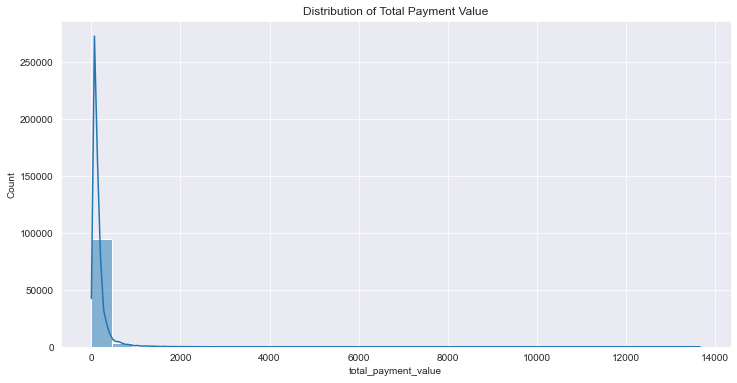

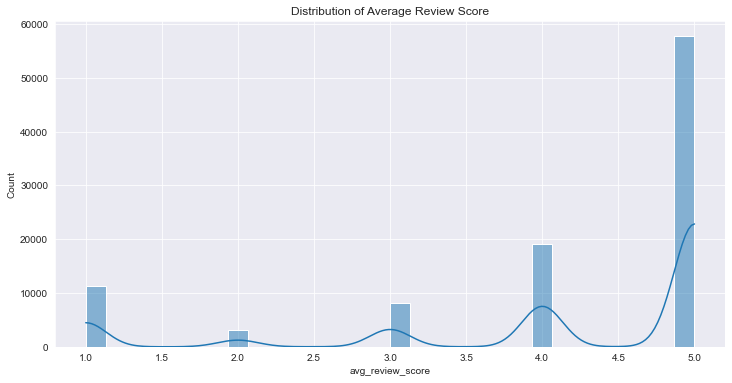

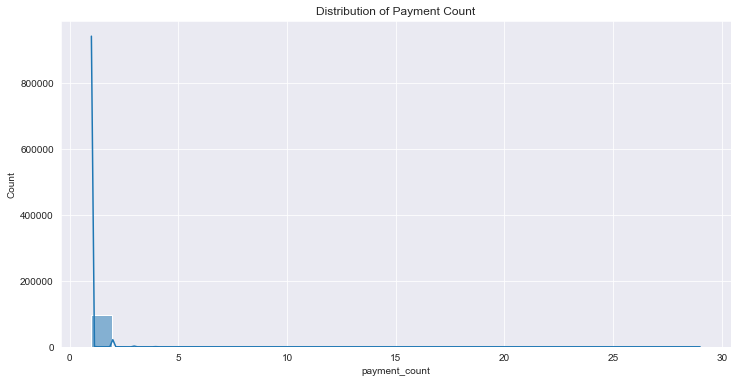

In [520]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualize distributions of key features
plt.figure(figsize=(12, 6))
sns.histplot(df_final['total_payment_value'], bins=30, kde=True)
plt.title('Distribution of Total Payment Value')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df_final['avg_review_score'], bins=30, kde=True)
plt.title('Distribution of Average Review Score')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df_final['payment_count'], bins=30, kde=True)
plt.title('Distribution of Payment Count')
plt.show()


Correlation matrix:
                          customer_zip_code_prefix  avg_review_score  \
customer_zip_code_prefix                  1.000000         -0.016621   
avg_review_score                         -0.016621          1.000000   
review_count                              0.001436         -0.004092   
total_payment_value                       0.057815         -0.047770   
payment_count                            -0.005990         -0.004590   

                          review_count  total_payment_value  payment_count  
customer_zip_code_prefix      0.001436             0.057815      -0.005990  
avg_review_score             -0.004092            -0.047770      -0.004590  
review_count                  1.000000            -0.009790       0.005421  
total_payment_value          -0.009790             1.000000       0.002037  
payment_count                 0.005421             0.002037       1.000000  


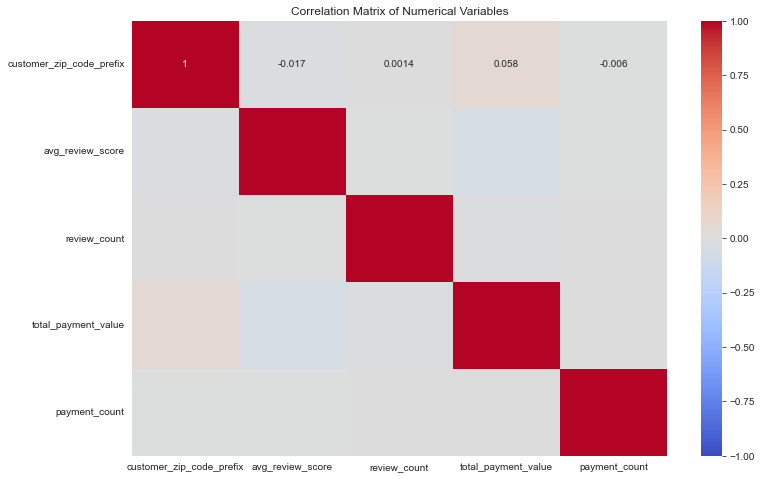

In [521]:
# Correlation matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Select the relevant numerical variables (excluding 'index_order' and 'index_customer')
numerical_vars = ['customer_zip_code_prefix', 'avg_review_score', 'review_count', 'total_payment_value', 'payment_count']

# Compute the correlation matrix
correlation_matrix = df_final[numerical_vars].corr()

# Print the correlation matrix
print("Correlation matrix:")
print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()



### Business Interpretation:

- Customer Location (Zip Code):
        Customer location, as indicated by zip code, does not have a significant impact on their behavior in terms of review scores, number of reviews, payment value, or payment count. This means marketing strategies and customer satisfaction efforts do not need to be heavily tailored based on customer location.

- Customer Reviews:
        The average review score and the number of reviews a customer leaves are largely independent of their payment behavior. This implies that a customer's satisfaction as reflected in reviews does not correlate strongly with how much they spend or how many payments they make.

- Customer Payments:
        The total payment value and the number of payments a customer makes are almost independent of their review scores and review count. This suggests that higher spending customers are not necessarily the ones who leave more or better reviews.

- Segmenting Customers:

    For segmentation purposes, it might be more beneficial to focus on variables other than those analyzed here, such as purchase frequency, recency of purchases, and specific product categories of interest to the customer. 
        

### Percentage of repeat purchases

In [522]:
# checking how many customers have purchased multiple times

import pandas as pd
import numpy as np
import os

repeat_customers = df_final[df_final['payment_count'] > 1]
num_repeat_customers = len(repeat_customers)
num_total_customers = len(df_final)
repeat_customer_percentage = (num_repeat_customers / num_total_customers) * 100
print(f"Percentage of customers with multiple purchases: {repeat_customer_percentage:.2f}%")


Percentage of customers with multiple purchases: 2.98%


### Visualizing Repeat Purchase Behavior Pie Chart

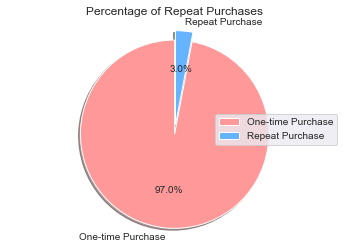

In [523]:
import matplotlib.pyplot as plt

# Data for pie chart
labels = ['One-time Purchase', 'Repeat Purchase']
sizes = [100 - repeat_customer_percentage, repeat_customer_percentage]
colors = ['#ff9999','#66b3ff']
explode = (0, 0.1)  # explode the 2nd slice (Repeat Purchase)

# Plotting the pie chart
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Percentage of Repeat Purchases')
plt.legend(labels, loc="center right", fontsize=10)
plt.show()


### Top 5 Product Categories by Sales

    product_category_name  sales
0         cama_mesa_banho   9213
1            beleza_saude   8764
2           esporte_lazer   7648
3  informatica_acessorios   6637
4        moveis_decoracao   6243
Total sales: 99441


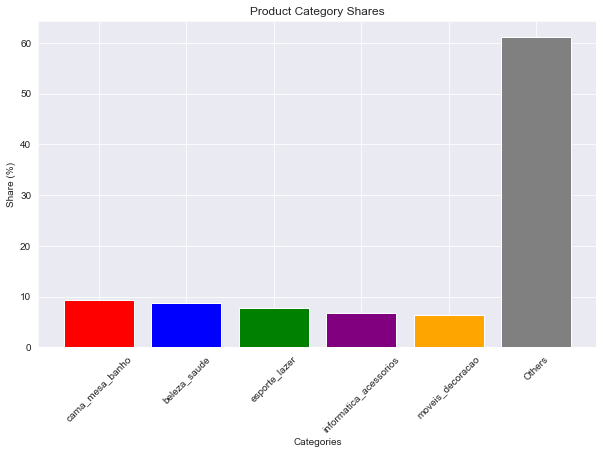

In [524]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


# Check if 'product_categories' column exists after merge
if 'product_categories' in df_final.columns:
    # Step 1: Count the number of times each product category appears
    product_categories = df_final['product_categories'].value_counts().reset_index()
    product_categories.columns = ['product_category_name', 'sales']
    print(product_categories.head())

    # Step 2: Calculate total sales for all categories
    total_sales = product_categories['sales'].sum()
    print("Total sales:", total_sales)

    # Step 3: Calculate the share of each category in total sales
    product_categories['share'] = (product_categories['sales'] / total_sales) * 100

    # Step 4: Create a DataFrame with these shares
    top_categories = product_categories.head(5).copy()
    other_share = 100 - top_categories['share'].sum()
    other_row = pd.DataFrame({'product_category_name': ['Others'], 'sales': [total_sales - top_categories['sales'].sum()], 'share': [other_share]})
    top_categories = pd.concat([top_categories, other_row], ignore_index=True)

    # Step 5: Visualize the shares with a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(top_categories['product_category_name'], top_categories['share'], color=['red', 'blue', 'green', 'purple', 'orange', 'grey'])
    plt.title('Product Category Shares')
    plt.xlabel('Categories')
    plt.ylabel('Share (%)')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("'product_categories' column not found in the DataFrame.")


### How the customers prefer to make payments.

Total number of payments: 99441
    Categories  Distribution
0  Credit Card     76.935067
1      Voucher      3.887732
2       Boleto     19.895214


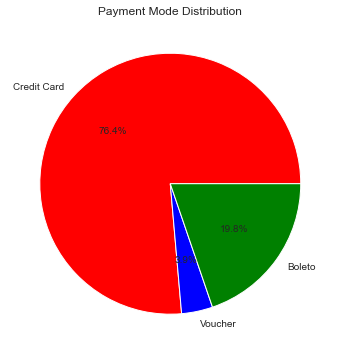

In [525]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Check if 'payment_types' column exists
if 'payment_types' in df_final.columns:
    # Total number of payments
    total_payments = len(df_final)
    print("Total number of payments:", total_payments)

    # Split payment types into separate rows
    payment_types_expanded = df_final['payment_types'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
    payment_types_expanded.name = 'payment_type'
    df_payments = df_final[['order_id']].join(payment_types_expanded)

    # Filter and count the number of payments by type
    payment_counts = df_payments['payment_type'].value_counts()
    total_card = payment_counts.get('credit_card', 0)
    total_voucher = payment_counts.get('voucher', 0)
    total_boleto = payment_counts.get('boleto', 0)

    # Calculate the share of each payment type
    card_share = (total_card / total_payments) * 100
    voucher_share = (total_voucher / total_payments) * 100
    boleto_share = (total_boleto / total_payments) * 100

    # Create a DataFrame with these shares
    payment_data = pd.DataFrame({
        'Categories': ['Credit Card', 'Voucher', 'Boleto'],
        'Distribution': [card_share, voucher_share, boleto_share]
    })
    print(payment_data)

    # Visualize the shares with a pie chart
    plt.figure(figsize=(10, 6))
    plt.pie(payment_data['Distribution'], labels=payment_data['Categories'], autopct='%1.1f%%', colors=['red', 'blue', 'green'])
    plt.title('Payment Mode Distribution')
    plt.show()
else:
    print("'payment_types' column not found in the DataFrame.")


### RFM analysis?
- RFM analysis is a basic model for customer segmentation or customer segmentation based on customer buying behavior. You must focus on three variables: R, F, and M.

- Recency (R) is how long it has been since the customer last purchased the product. It can be used as the date we want to study (Fixed date) or any date to start building the model (Flexible date).
- Frequency (F) is the frequency of customer purchases. Or how often do customers return to buy products from the store? Of course, this model may be suitable for products that are purchased repeatedly, such as food or cosmetics, etc., if they are products that have no chance of being repurchased at all. This may make it difficult to segment (distinguish) customers.
- Monetary (M) is the value of all goods. or the total amount the customer has paid the store since the first purchase. Until the day the model started

### Determine which scaling method (MinMaxScaler, StandardScaler, or RobustScaler) to use for your dataset, and why.
- Step 1: Define RFM Features

- Recency: The number of days since the customer's last purchase.
- Frequency: The number of purchases the customer has made.
- Monetary: The total amount of money spent by the customer.
- Step 2: Create RFM Features

### Calculate RFM Scores

![data_schema.PNG](../data/segmentation.PNG)

In [526]:
import pandas as pd
from datetime import datetime

# Assuming df_final is already loaded

# Convert 'order_purchase_timestamp' to datetime if not already
# This line ensures that the order_purchase_timestamp column is in datetime format, which is necessary for date calculations.
df_final['order_purchase_timestamp'] = pd.to_datetime(df_final['order_purchase_timestamp'], errors='coerce')

# Define the current date for recency calculation using the latest date in the dataset
# This line sets the current date to the latest date in the order_purchase_timestamp column. This date is used to calculate the recency of customer orders.
current_date = df_final['order_purchase_timestamp'].max()

# Calculate RFM features
# Recency: The number of days since the last purchase. Calculated as the difference between the current_date and the most recent order_purchase_timestamp for each customer.
# Frequency: The total number of orders. This is the count of order_id for each customer.
# Monetary: The total amount spent. This is the sum of total_payment_value for each customer.
RFMScores = df_final.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (current_date - x.max()).days,
    'order_id': 'count',
    'total_payment_value': 'sum'
}).reset_index()

# Rename the columns for clarity
RFMScores.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary']

# Display the RFM table
print(RFMScores.head())

                 customer_unique_id  Recency  Frequency  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2      160          1    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      163          1     27.19
2  0000f46a3911fa3c0805444483337064      585          1     86.22
3  0000f6ccb0745a6a4b88665a16c9f078      369          1     43.62
4  0004aac84e0df4da2b147fca70cf8255      336          1    196.89


In [527]:
# Describe Statistics Recency, Frequency, Monetary
RFMScores[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,96096.000000,96096.000000,96096.000000
mean,287.735691,1.034809,166.593588
std,153.414676,0.214384,231.427792
min,0.000000,1.000000,0.000000
25%,163.000000,1.000000,63.120000
50%,268.000000,1.000000,108.000000
75%,397.000000,1.000000,183.530000
max,772.000000,17.000000,13664.080000


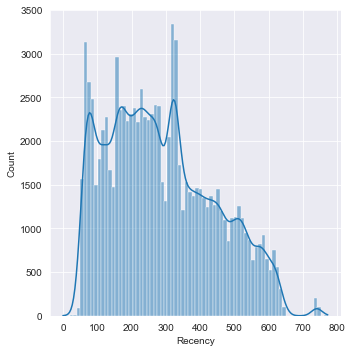

In [528]:
# Recency distribution plot
import seaborn as sns
x = RFMScores['Recency']
ax = sns.displot(x, kde=True)

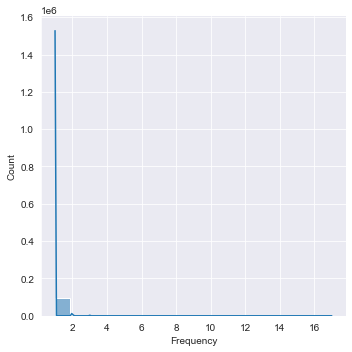

In [529]:
# Frequency distribution plot
x = RFMScores['Frequency']
ax = sns.displot(x, kde=True)

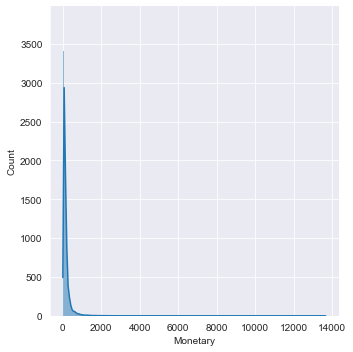

In [530]:
# Monetary distribution plot
x = RFMScores['Monetary']
ax = sns.displot(x, kde=True)

In [531]:
#Split into four segments using quantiles
quantiles = RFMScores[['Recency', 'Frequency', 'Monetary']].quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.25: 163.0, 0.5: 268.0, 0.75: 397.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 63.12, 0.5: 108.0, 0.75: 183.53}}

In [532]:
# Function to create RFM segments
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4
    
def FMScore(x,p,d):    
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [533]:
#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency',quantiles))
RFMScores['F'] = RFMScores['Frequency'].apply(FMScore, args=('Frequency',quantiles))
RFMScores['M'] = RFMScores['Monetary'].apply(FMScore, args=('Monetary',quantiles))
RFMScores.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,1,4,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,1,4,4
2,0000f46a3911fa3c0805444483337064,585,1,86.22,4,4,3
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62,3,4,4
4,0004aac84e0df4da2b147fca70cf8255,336,1,196.89,3,4,1


In [534]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup value
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,1,4,2,142,7
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,1,4,4,144,9
2,0000f46a3911fa3c0805444483337064,585,1,86.22,4,4,3,443,11
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62,3,4,4,344,11
4,0004aac84e0df4da2b147fca70cf8255,336,1,196.89,3,4,1,341,8


In [535]:
# Define rfm_level function
def rfm_level(df):
    if df['RFMScore'] >= 9:
        return 'Champions'
    elif (df['RFMScore'] >= 8) and (df['RFMScore'] < 9):
        return 'Loyal'
    elif (df['RFMScore'] >= 7) and (df['RFMScore'] < 8):
        return 'Potential Loyalists'
    elif (df['RFMScore'] >= 6) and (df['RFMScore'] < 7):
        return 'Promising'
    elif (df['RFMScore'] >= 5) and (df['RFMScore'] < 6):
        return 'Needs Attention'
    else:
        return 'Require Activation'
    
RFMScores['RFMLevel'] = RFMScores.apply(rfm_level, axis=1)
RFMScores.reset_index().head(20)

,index,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFMLevel
0,0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,1,4,2,142,7,Potential Loyalists
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,1,4,4,144,9,Champions
2,2,0000f46a3911fa3c0805444483337064,585,1,86.22,4,4,3,443,11,Champions
3,3,0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62,3,4,4,344,11,Champions
4,4,0004aac84e0df4da2b147fca70cf8255,336,1,196.89,3,4,1,341,8,Loyal
5,5,0004bd2a26a76fe21f786e4fbd80607f,194,1,166.98,2,4,2,242,8,Loyal
6,6,00050ab1314c0e55a6ca13cf7181fecf,180,1,35.38,2,4,4,244,10,Champions
7,7,00053a61a98854899e70ed204dd4bafe,231,1,419.18,2,4,1,241,7,Potential Loyalists
8,8,0005e1862207bf6ccc02e4228effd9a0,591,1,150.12,4,4,2,442,10,Champions
9,9,0005ef4cd20d2893f0d9fbd94d3c0d97,219,1,129.76,2,4,2,242,8,Loyal


In [536]:
#Validate the data for RFMGroup = 111
RFMScores[RFMScores['RFMGroup']=='111'].sort_values('Monetary', ascending=False).reset_index().head(10)

,index,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFMLevel
0,26456,46450c74a0d8c5ca9395da1daac6c120,60,3,9553.02,1,1,1,111,3,Require Activation
1,75269,c8460e4251689ba205045f3ea17884a1,70,4,4655.91,1,1,1,111,3,Require Activation
2,46292,7b0eaf68a16e4808e5388c67345033c9,151,2,2340.08,1,1,1,111,3,Require Activation
3,54182,906a8a4ec9f3d4c3e64fa6d1c4fe6009,89,2,2020.86,1,1,1,111,3,Require Activation
4,1242,0341bbd5c969923a0f801b9e2d10a7b8,140,2,1999.68,1,1,1,111,3,Require Activation
5,30980,525cda9909aa001ebed396f6e55eae01,70,2,1782.90,1,1,1,111,3,Require Activation
6,29990,4facc2e6fbc2bffab2fea92d2b4aa7e4,64,4,1760.75,1,1,1,111,3,Require Activation
7,21638,397b44d5bb99eabf54ea9c2b41ebb905,121,4,1756.53,1,1,1,111,3,Require Activation
8,51020,87c9e7ba960e4c2e6bd786b162adc639,157,2,1653.98,1,1,1,111,3,Require Activation
9,95534,fe81bb32c243a86b2f86fbf053fe6140,118,5,1590.76,1,1,1,111,3,Require Activation


### Observations:
- If the RFMGroup is '111', it indicates that the customer has the highest recency (R = 1), lowest frequency (F = 1), and lowest monetary value (M = 1). This combination suggests that the customer made a recent purchase but has low purchase frequency and spending, classifying them as 'Require Activation'. This segment requires marketing efforts to encourage more frequent and higher-value purchases to move them into more loyal and profitable segments. This validates the classification strategy, ensuring targeted efforts to improve customer engagement.

### Add the RFM scores and segments to the original DataFrame

In [537]:
# add the RFM scores and segments to the original DataFrame
df_final = pd.merge(df_final, RFMScores, on='customer_unique_id', how='left')
df_final.head()

,customer_unique_id,index_order,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_customer,...,days_early_or_late,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFMLevel
0,7c396fd4830fd04220f754e42b4e5bff,0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,70296,...,-8,380,2,82.82,3,1,3,313,7,Potential Loyalists
1,af07308b275d755c9edb36a90c618231,1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,77027,...,-6,84,1,141.46,1,4,2,142,7,Potential Loyalists
2,3a653a41f6f9fc3d2a113cf8398680e8,2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,554,...,-18,70,1,179.12,1,4,2,142,7,Potential Loyalists
3,7c142cf63193a1473d2e66489a9ae977,3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,61081,...,-13,332,1,72.20,3,4,3,343,10,Champions
4,72632f0f9dd73dfee390c9b22eb56dd6,4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,67263,...,-10,245,1,28.62,2,4,4,244,10,Champions


### Scaling method Analysis
- MinMaxScaler: Transform features to a scale of 0 to 1.
- StandardScaler: Standardize features to have a mean of 0 and standard deviation of 1.
- RobustScaler: Scale features using statistics that are robust to outliers.

- We can use cross-validation to determine which scaling method works best for your clustering model. Here, we demonstrate the scaling methods and visualize the results using KMeans and DBSCAN.
- Data sampling is used to reduce the computation time for the clustering algorithms and memory usage.


In [538]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Create a function to apply scaling and clustering
def evaluate_scaler(scaler, data):
    scaled_data = scaler.fit_transform(data)
    
    # KMeans Clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans_labels = kmeans.fit_predict(scaled_data)
    kmeans_silhouette = silhouette_score(scaled_data, kmeans_labels)
    
    # DBSCAN Clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(scaled_data)
    dbscan_silhouette = silhouette_score(scaled_data, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
    
    return kmeans_silhouette, dbscan_silhouette

# Prepare RFM data for scaling
rfm_features = RFMScores[['Recency', 'Frequency', 'Monetary']]

# Use a subset of the data for evaluation
rfm_sample = rfm_features.sample(n=10000, random_state=42)

# Evaluate each scaler
scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler()
}

results = {}
for scaler_name, scaler in scalers.items():
    kmeans_silhouette, dbscan_silhouette = evaluate_scaler(scaler, rfm_sample)
    results[scaler_name] = {'KMeans': kmeans_silhouette, 'DBSCAN': dbscan_silhouette}

# Display the results
print("Silhouette Scores for different scalers:")
for scaler_name, scores in results.items():
    print(f"{scaler_name} - KMeans: {scores['KMeans']:.4f}, DBSCAN: {scores['DBSCAN']:.4f}")


Silhouette Scores for different scalers:
MinMaxScaler - KMeans: 0.5151, DBSCAN: 0.7682
StandardScaler - KMeans: 0.4517, DBSCAN: 0.4583
RobustScaler - KMeans: 0.6293, DBSCAN: 0.1918


### Conclusion:
- **Understanding Silhouette Scores and Choosing the Best Scaling Method**

- Silhouette scores help evaluate the quality of clusters formed by a clustering algorithm. The score ranges from -1 to 1, where a higher value indicates better-defined clusters. Here's a simple explanation of how to interpret your results:

  - **Silhouette Score Range**:
    - Close to 1: Clusters are well-separated from each other.
    - Close to 0: Clusters are overlapping or not well-defined.
    - Negative values: Points may be assigned to the wrong cluster.

- **Results Interpretation**

  - The results are as follows:

    - **MinMaxScaler**:
      - KMeans: 0.5151
      - DBSCAN: 0.7682
    - **StandardScaler**:
      - KMeans: 0.4517
      - DBSCAN: 0.4583
    - **RobustScaler**:
      - KMeans: 0.6293
      - DBSCAN: 0.1918

- **Choosing the Best Method**

  - **KMeans Clustering**:
    - The RobustScaler gives the highest silhouette score for KMeans (0.6293). This suggests that using the RobustScaler results in better-defined clusters when using KMeans compared to the other scalers.

  - **DBSCAN Clustering**:
    - The MinMaxScaler gives the highest silhouette score for DBSCAN (0.7682). This indicates that using the MinMaxScaler results in better-defined clusters with DBSCAN.

- **Conclusion**

  - For **KMeans**, the RobustScaler is the best choice.
  - For **DBSCAN**, the MinMaxScaler is the best choice.

- **Next Steps**

  - **KMeans Clustering with RobustScaler**:
    - Apply the RobustScaler to the entire dataset before performing KMeans clustering.
  - **DBSCAN Clustering with MinMaxScaler**:
    - Apply the MinMaxScaler to the entire dataset before performing DBSCAN clustering.

In [539]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_unique_id             99441 non-null  object        
 1   index_order                    99441 non-null  int64         
 2   order_id                       99441 non-null  object        
 3   order_status                   99441 non-null  object        
 4   order_purchase_timestamp       99441 non-null  datetime64[ns]
 5   order_approved_at              99441 non-null  datetime64[ns]
 6   order_delivered_carrier_date   99441 non-null  datetime64[ns]
 7   order_delivered_customer_date  99441 non-null  datetime64[ns]
 8   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 9   index_customer                 99441 non-null  int64         
 10  customer_zip_code_prefix       99441 non-null  int64         
 11  customer_city  

### Normalization for KMeans with RobustScaler and average review score and review count features

In [540]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder
import pandas as pd

# Assuming df_final is your original DataFrame
df_final_original = df_final.copy()  # Make a copy to preserve the original

# Select the numeric and categorical features
numeric_features = ['Recency', 'Frequency', 'Monetary', 'avg_review_score', 'review_count', 'RFMScore']
categorical_features = ['RFMLevel', 'RFMGroup']

# Apply RobustScaler to numeric features
robust_scaler = RobustScaler()
df_final[numeric_features] = robust_scaler.fit_transform(df_final[numeric_features])

# Apply OneHotEncoder to categorical features
one_hot_encoder = OneHotEncoder(sparse=False, drop='first')
encoded_categorical_data = one_hot_encoder.fit_transform(df_final[categorical_features])

# Convert encoded categorical data back to a DataFrame
encoded_categorical_df = pd.DataFrame(encoded_categorical_data, 
                                      columns=one_hot_encoder.get_feature_names_out(categorical_features))

# Reset index of the original DataFrame to match the one-hot encoded DataFrame
df_final.reset_index(drop=True, inplace=True)

# Concatenate the encoded categorical data with the original DataFrame
df_final = pd.concat([df_final, encoded_categorical_df], axis=1)

# Drop the original categorical columns
df_final.drop(columns=categorical_features, inplace=True)

# Copy the normalized and encoded data to a new DataFrame for KMeans
df_final_kmeans = df_final.copy()

# Verify the normalization and encoding
print("Normalized and Encoded DataFrame for KMeans head:")
df_final_kmeans.head()

Normalized and Encoded DataFrame for KMeans head:


,customer_unique_id,index_order,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_customer,...,RFMGroup_343,RFMGroup_344,RFMGroup_411,RFMGroup_412,RFMGroup_413,RFMGroup_414,RFMGroup_441,RFMGroup_442,RFMGroup_443,RFMGroup_444
0,7c396fd4830fd04220f754e42b4e5bff,0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,70296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,af07308b275d755c9edb36a90c618231,1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,77027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3a653a41f6f9fc3d2a113cf8398680e8,2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,554,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7c142cf63193a1473d2e66489a9ae977,3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,61081,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,72632f0f9dd73dfee390c9b22eb56dd6,4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,67263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Normalization for DBSCAN with MinMaxScaler without 'Avg_Review_Score' and 'Review_Count' features

In [541]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import pandas as pd

# Reset df_final to the original DataFrame before any transformations
df_final = df_final_original.copy()  # Restore the original data

# Select the numeric and categorical features
numeric_features = ['Recency', 'Frequency', 'Monetary', 'avg_review_score', 'review_count', 'RFMScore']
categorical_features = ['RFMLevel', 'RFMGroup']

# Apply MinMaxScaler to numeric features
minmax_scaler = MinMaxScaler()
df_final[numeric_features] = minmax_scaler.fit_transform(df_final[numeric_features])

# Apply OneHotEncoder to categorical features
one_hot_encoder = OneHotEncoder(sparse=False, drop='first')
encoded_categorical_data = one_hot_encoder.fit_transform(df_final[categorical_features])

# Convert encoded categorical data back to a DataFrame
encoded_categorical_df = pd.DataFrame(encoded_categorical_data, 
                                      columns=one_hot_encoder.get_feature_names_out(categorical_features))

# Reset index of the original DataFrame to match the one-hot encoded DataFrame
df_final.reset_index(drop=True, inplace=True)

# Concatenate the encoded categorical data with the original DataFrame
df_final = pd.concat([df_final, encoded_categorical_df], axis=1)

# Drop the original categorical columns
df_final.drop(columns=categorical_features, inplace=True)

# Copy the normalized and encoded data to a new DataFrame for DBSCAN
df_final_dbscan = df_final.copy()

# Verify the normalization and encoding
print("Normalized and Encoded DataFrame for DBSCAN head:")
df_final_dbscan.head()


Normalized and Encoded DataFrame for DBSCAN head:


,customer_unique_id,index_order,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_customer,...,RFMGroup_343,RFMGroup_344,RFMGroup_411,RFMGroup_412,RFMGroup_413,RFMGroup_414,RFMGroup_441,RFMGroup_442,RFMGroup_443,RFMGroup_444
0,7c396fd4830fd04220f754e42b4e5bff,0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,70296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,af07308b275d755c9edb36a90c618231,1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,77027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3a653a41f6f9fc3d2a113cf8398680e8,2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,554,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7c142cf63193a1473d2e66489a9ae977,3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,61081,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,72632f0f9dd73dfee390c9b22eb56dd6,4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,67263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
